I've set up a cronjob that executes the following command every minute:
```bash
top -b -n 1 | head --lines=5 | ts "[\%Y-\%m-\%d \%H:\%M:\%S]" >> ~/stats.log
```
This saves the header of the "top" command with a timestamp. After 24 hours of collecting data, I created a custom parser, that reads the timestamps and CPU stats from this file, and saves it as a csv file.

*Note: Steal time seems to oscillate a lot, and it peaks at the beginning of every minute, so some measurements may not fully represent the overall severity of the case* 

In [1]:
# import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime
import os.path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# import custom logparser
try:
    import converter
except:
    pass

In [2]:
# parse log if necessary, then read output
if os.path.exists("stats.log"):
    converter.parse_log_to_csv()
df = pd.read_csv("stats.csv")
df["timestamp"] = pd.to_datetime(df['timestamp'])

In [3]:
# calculate mean steal time
minutes_to_avg = 15
steal_mean = []
for i in range(len(df["steal_time"])):
    top = (minutes_to_avg+1)//2 if len(df["steal_time"])-i > (minutes_to_avg+1)/2 else len(df["steal_time"])-i
    bot = -(minutes_to_avg-1)//2 if i > (minutes_to_avg-1)/2 else -i
    steal_mean.append(np.mean([df["steal_time"][i+x] for x in range(bot, top)]))

In [4]:
def plot_cpu_data(from_timestamp, to_timestamp):
    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid()
    ax.plot(df["timestamp"], df["steal_time"], "g",label="Steal time")
    ax.plot(df["timestamp"], steal_mean, "r", label="15 minute mean steal time")
    ax.plot(df["timestamp"], df["usage"], "b", label="CPU Utilization")
    ax.xaxis_date()
    ax.set_ylabel("Percent")
    ax.set_xlabel("Timestamp")
    ax.set_title("From: {} To: {}".format(from_timestamp.strftime("%Y-%m-%d %H:%M:%S"), to_timestamp.strftime("%Y-%m-%d %H:%M:%S")))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(base=1/24/4))
    ax.yaxis.set_ticks(np.arange(0, 101, 10))
    ax.legend()
    plt.xlim((from_timestamp, to_timestamp))
    plt.show()

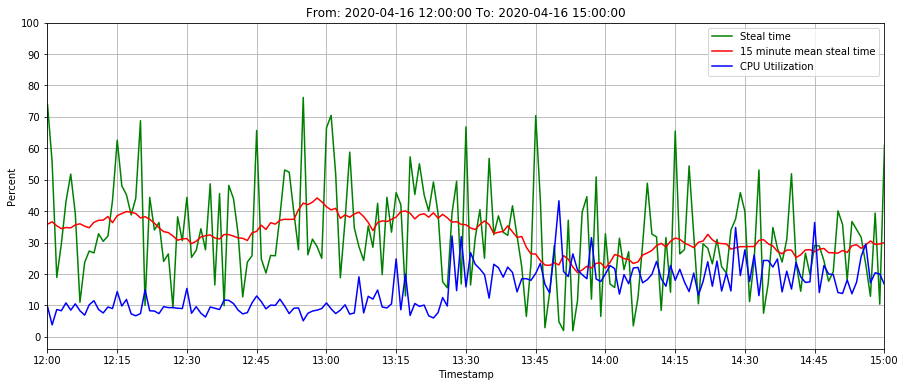

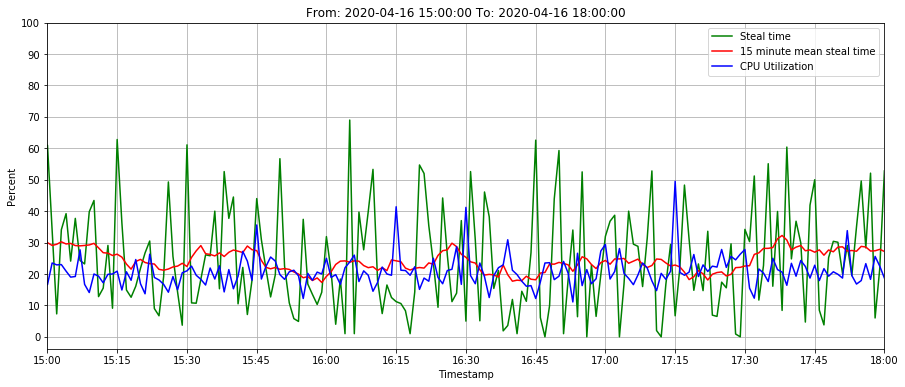

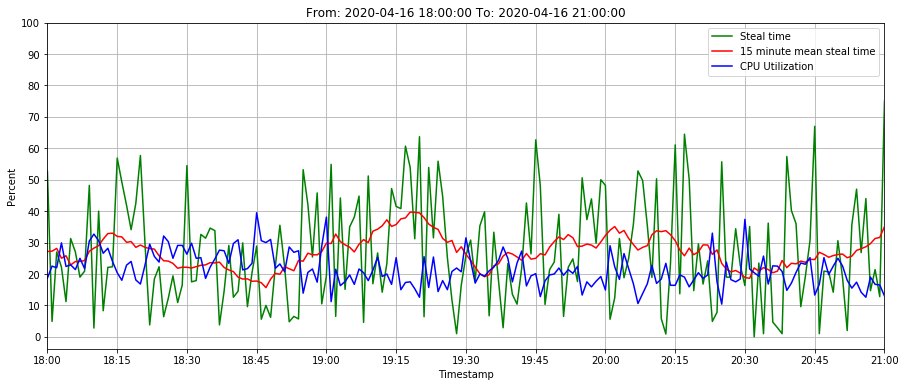

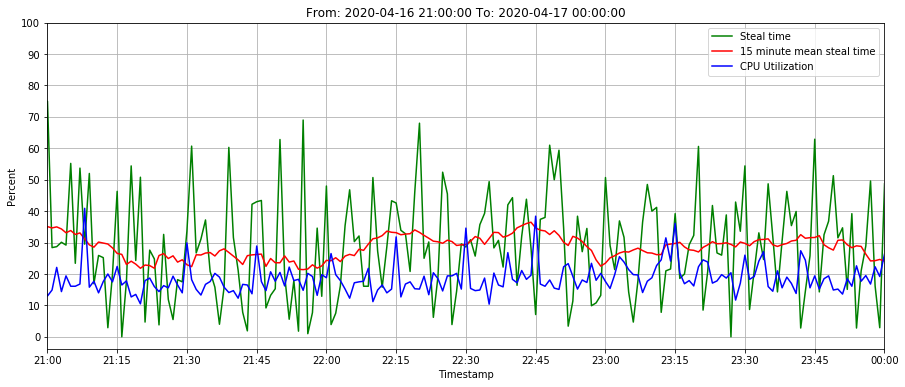

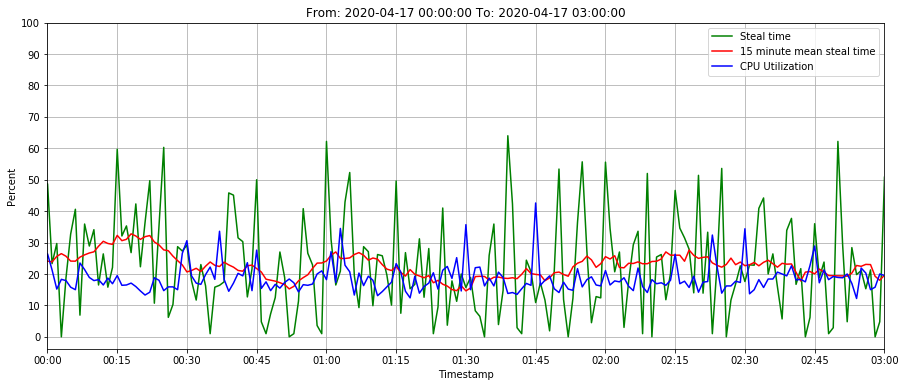

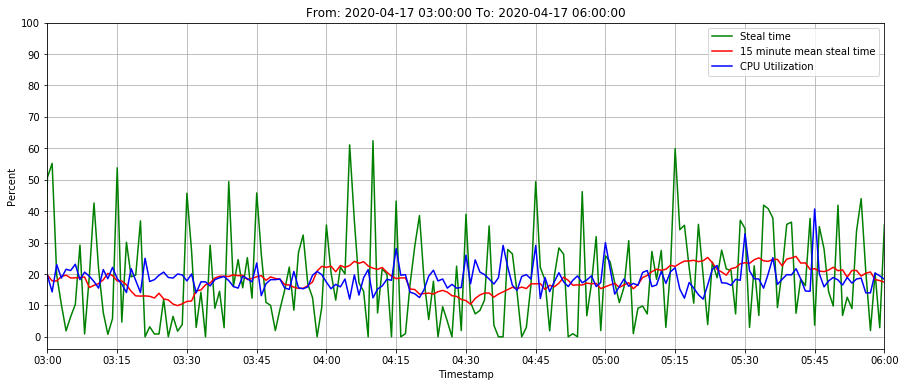

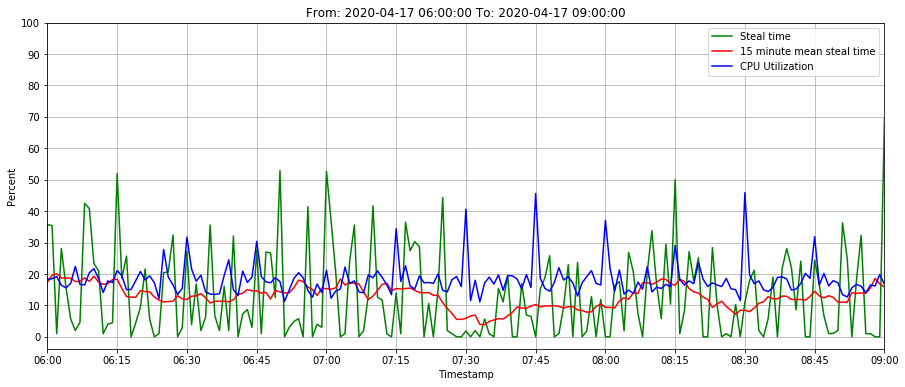

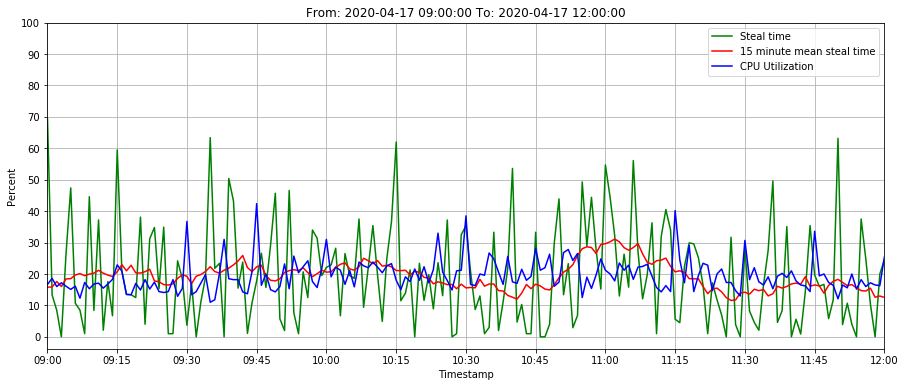

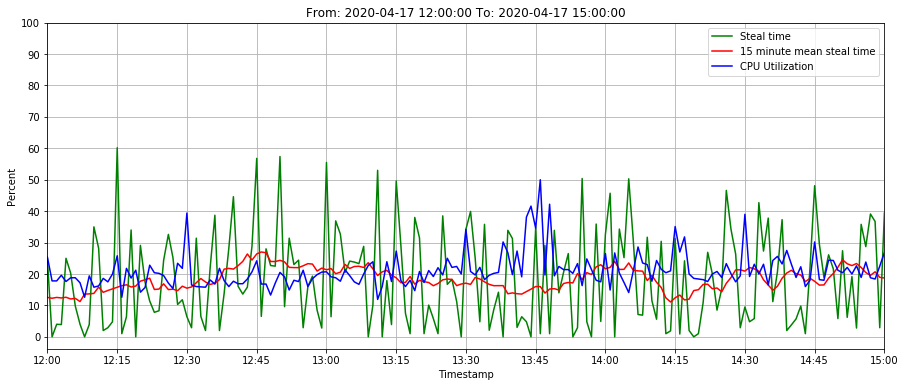

In [5]:
# plot every 3 hours from the specified timestamp
for i in range(9):
    start_ts = pd.Timestamp("2020-04-16 12:00")
    timedelta = pd.Timedelta("+3 h")
    from_ts = start_ts + timedelta * (i)
    to_ts = start_ts + timedelta * (i+1)
    plot_cpu_data(from_ts, to_ts)

**After I've been done with this report, the steal time went back to tolerable levels (under avg. 5%), and is only present in smaller spikes, so I consider the issue "resolved", altough no conclusion has been drawn yet. The report only showcases the condition of increased steal time.**